# Code Associated with Research Question 3

__Research Question 3__ <br>
"Do theta oscillations differ between _anterior_ and _posterior_ sections of the hippocampus?"

In [29]:
# common imports
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.ndimage import zoom, gaussian_filter # smoothing
import copy

# statistics
from scipy import stats
import mne # for permutation tests

# own libraries
import neuropsy as npsy

In [30]:
# [IMPORTANT] Set the hippocampal subfield and stimulus to be analyzed
hp_subfield = 'head'
stimulus    = 'Picture Placed'

#********** PARAMETERS **********#
path_data                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
path_results_Q1             = f'/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
path_results                = f'/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 3/Time-frequency Power Analysis/hippocampus-{hp_subfield}'

stimulus_list               = ['Picture Shown', 'Picture Placed']
cond_column                 = 'Condition (modified)'
conditions                  = ('not learned', 'correct', 'learned-1', 'learned')
hippocampus_subfields       = ('head', 'body & tail')
dict_subfields_regex        = {'head': r'Right_HP_head|Left_HP_head', 'body & tail': r'Right_HP_body|Left_HP_body|Right_HP_tail|Left_HP_tail'}

# plot parameters
timepoints                  = np.arange(0, 1280, 1)
frequencies                 = np.arange(2, 13, 1)
xticks                      = [0, 255, 511, 767, 1023, 1279]
xlabels                     = ["- 0.5 s", "stim", "0.5 s", "1 s", "1.5 s", "2 s"]
frequencies_plot            = np.insert(frequencies.astype(float), [0, len(frequencies)], [1.5, 12.5]) # define custom y ticks across frequencies but exclude first and last frequency labels as they the ticks are only for plotting purposes
yticks                      = frequencies_plot
ylabels                     = [int(frequencies_plot[i]) if i > 0 and i < len(frequencies_plot)-1 else "" for i in range(len(frequencies_plot))]

# used for 
n_frequencies               = len(frequencies)
n_timepoints                = len(timepoints)

# set up directory for saving results
if not os.path.exists(path_results) or not os.path.exists(f"{path_results}/data"):
    os.makedirs(path_results)
    os.makedirs(f"{path_results}/data")

### Load Previous Results

- results from Q1 are loaded
- channels from hippocampus subfield are selected
- trials are assigned to the condition according to the label in the experiment dataframe (see notebook <span style="color: green;">_PRE - categorise trials.ipynb_</span>)
- a new condition is added, called _learned combined_

In [31]:
filename = f"{path_results_Q1}/data/1.2 tfr_power_results_{stimulus}.pkl"

# load previously computed time-frequency power for all subjects
load_start_time = time.time()
with open(filename, 'rb') as f:
    dict_tfr_power_results_Q1 = pickle.load(f)
print(f"Loading data took {time.time()-load_start_time:.2f} seconds.")

# get conditions and subject ids from the loaded results dictionary
subject_ids = list(dict_tfr_power_results_Q1.keys())


#################### SELECT CHANNELS IN HIPPOCAMPUS SUBFIELD ####################
select_ch_start_time = time.time()
for subject_id in subject_ids:
    # load subject data (only channel dataframe)
    data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed', load_ieeg=False, load_exp=False, load_chan=True, load_targets=False, load_ied=False)
    
    # get channel names that are in the hippocampal subfield
    regex_pattern = dict_subfields_regex[hp_subfield]
    hp_subfield_chans = data.df_chan[data.df_chan['DK_Subfields'].str.contains(regex_pattern, regex=True, case=False)]['name'].tolist()
    
    # check if subject has any channels in the hippocampal subfield
    if len(hp_subfield_chans) == 0:
        print(f"Subject {subject_id} has no channels in the hippocampal subfield.")
        # remove subject from dictionary
        dict_tfr_power_results_Q1.pop(subject_id)
    else:
        # remove channels that are not in the hippocampal subfield
        for ch in list(dict_tfr_power_results_Q1[subject_id].keys()):
            if ch not in hp_subfield_chans:
                dict_tfr_power_results_Q1[subject_id].pop(ch)
# ensure that the subject ids are updated
subject_ids = list(dict_tfr_power_results_Q1.keys())
print(f"Selecting channels done in {time.time()-select_ch_start_time:.2f} seconds.")


#################### ASSIGN TRIALS TO CONDITIONS ####################
dict_tfr_power_results = {c: {s: {} for s in subject_ids} for c in conditions}
assign_start_time = time.time()
for condition in conditions:
    for subject_id in subject_ids:
        dict_tfr_power_results[condition][subject_id] = {ch: {} for ch in dict_tfr_power_results_Q1[subject_id].keys()}
        
        # load subject data (only experiment dataframe)
        data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
        data.load(load_saved=True, postfix='preprocessed', load_ieeg=False, load_chan=False, load_targets=False, load_ied=False)
        
        # iterate over channels
        for ch in dict_tfr_power_results_Q1[subject_id].keys():
            # iterate over trials
            for trial in dict_tfr_power_results_Q1[subject_id][ch].keys():
                # get trial condition from experiment dataframe
                trial_condition = data.df_exp[data.df_exp['Trial Identifier'] == trial][cond_column].values[0]
                # assign trial respectively in the new dictionary
                if trial_condition == condition:
                    dict_tfr_power_results[condition][subject_id][ch][trial] = dict_tfr_power_results_Q1[subject_id][ch][trial]
print(f"Assigning trials to conditions done in {time.time()-assign_start_time:.2f} seconds.")
    

#################### GET AVERAGES AS DICT AND (FOR SOME) ARRAY ####################
average_start_time = time.time()
# compute channel average (average each channel across all trials)
dict_tfr_power_results_chan_avg = {c: {s: {} for s in subject_ids} for c in conditions}
for condition in conditions:
    for subject_id in subject_ids:
        for ch in dict_tfr_power_results[condition][subject_id].keys():
            dict_tfr_power_results_chan_avg[condition][subject_id][ch] = np.mean(list(dict_tfr_power_results[condition][subject_id][ch].values()), axis=0)
            
# compute subject average (average each subject across all channels)
dict_tfr_power_results_subj_avg     = {c: {s: {} for s in subject_ids} for c in conditions}
arr_tfr_power_results_subj_avg      = np.zeros((len(conditions), len(subject_ids), n_frequencies, n_timepoints))
for i, condition in enumerate(conditions):
    for j, subject_id in enumerate(subject_ids):
        dict_tfr_power_results_subj_avg[condition][subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[condition][subject_id].values()), axis=0)
        arr_tfr_power_results_subj_avg[i, j] = dict_tfr_power_results_subj_avg[condition][subject_id]
    
# compute condition average (average each condition across all subjects)
dict_tfr_power_results_cond_avg     = {c: {} for c in conditions}
arr_tfr_power_results_cond_avg      = np.zeros((len(conditions), n_frequencies, n_timepoints))
for i, condition in enumerate(conditions):
    dict_tfr_power_results_cond_avg[condition] = np.mean(list(dict_tfr_power_results_subj_avg[condition].values()), axis=0)
    arr_tfr_power_results_cond_avg[i] = dict_tfr_power_results_cond_avg[condition]
print(f"Computing averages done in {time.time()-average_start_time:.2f} seconds.")

    
# ********** ADD CONDITION 'LEARNED COMBINED' TO DICTS AND ARRAYS ********** #
# add new condition to channel average results
dict_tfr_power_results_chan_avg['learned combined'] = {s: {} for s in subject_ids}
for subject_id in subject_ids:
    for ch in dict_tfr_power_results_chan_avg[conditions[0]][subject_id].keys():
        dict_tfr_power_results_chan_avg['learned combined'][subject_id][ch] = np.mean([dict_tfr_power_results_chan_avg[c][subject_id][ch] for c in ('learned-1', 'learned')], axis=0)
# note: cannot create array of channel averages as they have different shapes

# add new condition to subject average results
dict_tfr_power_results_subj_avg['learned combined'] = {}
for subject_id in subject_ids:
    dict_tfr_power_results_subj_avg['learned combined'][subject_id] = np.mean([dict_tfr_power_results_subj_avg[c][subject_id] for c in ('learned-1', 'learned')], axis=0)
# stack new condtion to array
tmp_list = []
for subject_id in subject_ids:
    tmp_list.append(dict_tfr_power_results_subj_avg['learned combined'][subject_id])
arr_tfr_power_results_subj_avg = np.vstack((arr_tfr_power_results_subj_avg, np.asanyarray(tmp_list)[np.newaxis, :]))
    
# add new condition to condition average results
for subject_id in subject_ids:
    dict_tfr_power_results_cond_avg['learned combined'] = np.mean([dict_tfr_power_results_cond_avg[c] for c in ('learned-1', 'learned')], axis=0)
# stack new condtion to array
arr_tfr_power_results_cond_avg = np.vstack((arr_tfr_power_results_cond_avg, dict_tfr_power_results_cond_avg['learned combined'][np.newaxis, :]))
print("New condition 'learned combined' added to results.")

# clean up to save memory
del dict_tfr_power_results

Loading data took 24.31 seconds.
Subject 11 has no channels in the hippocampal subfield.
Selecting channels done in 0.22 seconds.
Assigning trials to conditions done in 6.37 seconds.
Computing averages done in 0.16 seconds.
New condition 'learned combined' added to results.


# 1. Time-Frequency Analysis

The time-frequency representation has already been computed in Q1, the steps taken here include:
- load previous results from Q1
- select channels that are within the selected hippocampal subfield (_head_ or _body and tail_)
- divide results into conditions

### 1.2 Visualise Time-Frequency Representation - Channel Average

plot each channel separately for each subject, plot shows all conditions separately and the average across trials.

In [32]:
# individual color bars (True/False)
individ_cbars = False

for subject_id in subject_ids:
    for ch in list(dict_tfr_power_results_chan_avg[conditions[0]][subject_id].keys()):
        
        fig, ax = plt.subplots(ncols=len(conditions), nrows=1, figsize=(25, 5), layout='compressed')
        
        for i, condition in enumerate(conditions):
            
            im = ax[i].imshow(
                dict_tfr_power_results_chan_avg[condition][subject_id][ch],
                aspect='auto',
                extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
                origin='lower', 
                vmax=np.max(dict_tfr_power_results_chan_avg[condition][subject_id][ch]) if individ_cbars else 3,
                vmin=-np.max(dict_tfr_power_results_chan_avg[condition][subject_id][ch]) if individ_cbars else -3,
                cmap='RdBu_r',
                interpolation='hanning')
            ax[i].set_title(f'{condition} - {ch}', fontsize=12)
            ax[0].set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
            ax[i].set_yticks(yticks, ylabels, fontsize=10)
            ax[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
            
            # add line at onset and offset
            ax[i].axvline(x=255, color='black', linestyle='--', linewidth=1.)
            
            if individ_cbars:
                # add colorbar for each plot separately
                cbar = plt.colorbar(im, ax=ax[i], shrink=0.70, pad=0.01, orientation="vertical")
                if i == len(conditions)-1: cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)
        
        if not individ_cbars:
            # add colorbar for the entire figure
            cbar = plt.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70, pad=0.01, orientation="vertical")
            cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)
        fig.suptitle(f"Hippocampus-{hp_subfield}, Subject {subject_id}, Channel Average ({stimulus})", fontsize=14, y=1.06, x=.49)
        
        full_save_path = f"{path_results}/1.2 {stimulus}_tfr_sub{subject_id}_{ch}_power.png"
        fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure for subject {subject_id} at {repr(full_save_path)}")
        plt.close(fig)
        # plt.show()
            
    # break

Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 3/Time-frequency Power Analysis/hippocampus-head/1.2 Picture Placed_tfr_sub03_B' 02_power.png"
Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 3/Time-frequency Power Analysis/hippocampus-head/1.2 Picture Placed_tfr_sub03_B' 03_power.png"
Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 3/Time-frequency Power Analysis/hippocampus-head/1.2 Picture Placed_tfr_sub03_B' 04_power.png"
Saved figure for subject 03 at "/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 3/Time-frequency Power Analysis/hippocampus-head/1.2 Picture Placed_tfr_sub03_B' 05_power.png"
Saved figure for subject 04 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/result

### 1.3 Visualise Time-Frequency Representation - Subject Average

In [33]:
# individual color bars (True/False)
individ_cbars = False

#********** PLOT RESULTS **********#
for subject_id in subject_ids:
    
    fig, ax = plt.subplots(ncols=len(conditions), nrows=1, figsize=(25, 5), layout='compressed')
    
    for i, condition in enumerate(conditions):
            
        im = ax[i].imshow(
            dict_tfr_power_results_subj_avg[condition][subject_id], 
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower', 
            vmin=-np.max(dict_tfr_power_results_subj_avg[condition][subject_id]) if individ_cbars else -2,
            vmax=np.max(dict_tfr_power_results_subj_avg[condition][subject_id]) if individ_cbars else 2,
            cmap='RdBu_r',
            interpolation='hanning')
        
        ax[i].set_title(f'{condition}', fontsize=12)
        ax[0].set_ylabel('Frequency (Hz)', fontsize=11)        # only set ylabel for left most plots
        ax[i].set_yticks(yticks, ylabels, fontsize=10)
        ax[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
        
        # add line at onset and offset
        ax[i].axvline(x=255, color='black', linestyle='--', linewidth=1.)
        
        if individ_cbars:
            # add colorbar for the entire figure
            cbar = plt.colorbar(im, ax=ax[i], shrink=0.70, pad=0.01, orientation="vertical")
            if i == len(conditions)-1: cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)

    if not individ_cbars:
        # add colorbar for the entire figure
        cbar = plt.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70, pad=0.01, orientation="vertical")
        cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)
    fig.suptitle(f'Hippocampus-{hp_subfield}, Subject {subject_id} Average ({stimulus})', fontsize=14, y=1.06, x=.49)

    full_save_path = f"{path_results}/1.3 {stimulus}_tfr_sub{subject_id}_power.png"
    fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved figure for subject {subject_id} at {repr(full_save_path)}")
    plt.close(fig)
    # plt.show()
    
    # break

Saved figure for subject 03 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 3/Time-frequency Power Analysis/hippocampus-head/1.3 Picture Placed_tfr_sub03_power.png'
Saved figure for subject 04 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 3/Time-frequency Power Analysis/hippocampus-head/1.3 Picture Placed_tfr_sub04_power.png'
Saved figure for subject 05 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 3/Time-frequency Power Analysis/hippocampus-head/1.3 Picture Placed_tfr_sub05_power.png'
Saved figure for subject 07 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 3/Time-frequency Power Analysis/hippocampus-head/1.3 Picture Placed_tfr_sub07_power.png'
Saved figure for subject 09 at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 3/Ti

### 1.4 Visualise Time-Frequency Representation - Condition Average

In [34]:
# individual color bars (True/False)
individ_cbars = False

#********** PLOT RESULTS **********#
fig, ax = plt.subplots(ncols=len(conditions), nrows=1, figsize=(25, 5), layout='compressed')
for i, condition in enumerate(conditions):
        
    im = ax[i].imshow(
        dict_tfr_power_results_cond_avg[condition], 
        aspect='auto',
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        origin='lower', 
        vmin=-np.max(dict_tfr_power_results_cond_avg[condition]) if individ_cbars else -1,
        vmax=np.max(dict_tfr_power_results_cond_avg[condition]) if individ_cbars else 1,
        cmap='RdBu_r',
        interpolation='hanning')
    
    ax[i].set_title(f'{condition}', fontsize=12)
    ax[0].set_ylabel('Frequency (Hz)', fontsize=11)        # only set ylabel for left most plots
    ax[i].set_yticks(yticks, ylabels, fontsize=10)
    ax[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    
    # add line at stimulus onset
    ax[i].axvline(x=255, color='black', linestyle='--', linewidth=1.)
    
    if individ_cbars:
        # add colorbar for the entire figure
        cbar = plt.colorbar(im, ax=ax[i], shrink=0.70, pad=0.01, orientation="vertical")
        if i == len(conditions)-1: cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)

if not individ_cbars:
    # add colorbar for the entire figure
    cbar = plt.colorbar(im, ax=ax.ravel().tolist(), shrink=0.70, pad=0.01, orientation="vertical")
    cbar.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)
fig.suptitle(f'Hippocampus-{hp_subfield}, Condition Average ({stimulus})', fontsize=14, y=1.06, x=.49)

full_save_path = f"{path_results}/1.4 {stimulus}_tfr_condition_power.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
print(f"Saved figure at {repr(full_save_path)}")
plt.close(fig)
# plt.show()

Saved figure at '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 3/Time-frequency Power Analysis/hippocampus-head/1.4 Picture Placed_tfr_condition_power.png'


# 2. Statistics

### 2.2 Permutation Test

#### 2.2.1 Conditon vs. Baseline

In [35]:
tfr_data        = arr_tfr_power_results_subj_avg

# ************ STATISTICS ************
alpha           = 0.05                                                                      # significance level
df              = len(subject_ids) - 1                                                      # degrees of freedom
threshold       = stats.t.ppf(1 - alpha / 2, df)                                            # divided by 2 for two-tailed test
stat_fun        = lambda x, y: stats.ttest_rel(x, y, axis=0, alternative='two-sided')[0]    # paired two-sample t-test
print(f"Threshold: {threshold}")


# ************ PERMUTATION TEST ************
statistics      = {c: {'T_obs': None, 'clusters': None, 'cluster_p_values': None, 'H0': None} for c in conditions}

for i, condition in enumerate(conditions):
    print(f"\nCondition: {condition}")
    
    # reshape data to fit permutation function
    tfr_condition = tfr_data[i]#.reshape(len(subject_ids), -1)
    tfr_baseline = np.zeros_like(tfr_condition) # baseline is all zeros (data is already baseline corrected)
    
    # define combined input X to permutation function
    X = [tfr_condition, tfr_baseline]
    
    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
        X,
        threshold=threshold,
        n_permutations=1000, 
        tail=1, 
        n_jobs=-1, 
        seed=23,
        out_type='mask',
        stat_fun=stat_fun)
    
    statistics[condition]['T_obs'] = T_obs #.reshape(n_freqs, n_times) # reshape back to time-frequency shape
    statistics[condition]['clusters'] = clusters
    statistics[condition]['cluster_p_values'] = cluster_p_values
    statistics[condition]['H0'] = H0
    
    del X, T_obs, clusters, cluster_p_values, H0
    
    
#********** SAVE STATISTICS RESULTS **********#
filename = f"{path_results}/data/2.2.1 {stimulus}_stat_permutation_condition_vs_baseline.pkl"
with open(filename, 'wb') as f:
    pickle.dump(statistics, f)

Threshold: 2.2621571627409915

Condition: not learned
stat_fun(H1): min=-2.6059147522459845 max=4.941578148662758
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]


Condition: correct
stat_fun(H1): min=-7.690748215827166 max=2.934602054398047
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]


Condition: learned-1
stat_fun(H1): min=-5.799657864724549 max=6.461778947517041
Running initial clustering …
Found 10 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]


Condition: learned
stat_fun(H1): min=-2.0431538379283967 max=4.169944776781316
Running initial clustering …
Found 16 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]


Condition: not learned
NOT SIGNIFICANT: cluster 1 with p-value 0.287
NOT SIGNIFICANT: cluster 2 with p-value 0.178
NOT SIGNIFICANT: cluster 3 with p-value 0.359

Condition: correct
NOT SIGNIFICANT: cluster 1 with p-value 0.487
NOT SIGNIFICANT: cluster 2 with p-value 0.43

Condition: learned-1
SIGNIFICANT: cluster 1 with p-value 0.012
NOT SIGNIFICANT: cluster 2 with p-value 0.673
NOT SIGNIFICANT: cluster 3 with p-value 0.743
NOT SIGNIFICANT: cluster 4 with p-value 0.553
NOT SIGNIFICANT: cluster 5 with p-value 0.763
NOT SIGNIFICANT: cluster 6 with p-value 0.865
NOT SIGNIFICANT: cluster 7 with p-value 0.889
NOT SIGNIFICANT: cluster 8 with p-value 0.796
NOT SIGNIFICANT: cluster 9 with p-value 0.879
NOT SIGNIFICANT: cluster 10 with p-value 0.846

Condition: learned
SIGNIFICANT: cluster 1 with p-value 0.016
NOT SIGNIFICANT: cluster 2 with p-value 0.641
NOT SIGNIFICANT: cluster 3 with p-value 0.419
NOT SIGNIFICANT: cluster 4 with p-value 0.783
NOT SIGNIFICANT: cluster 5 with p-value 0.647
NO

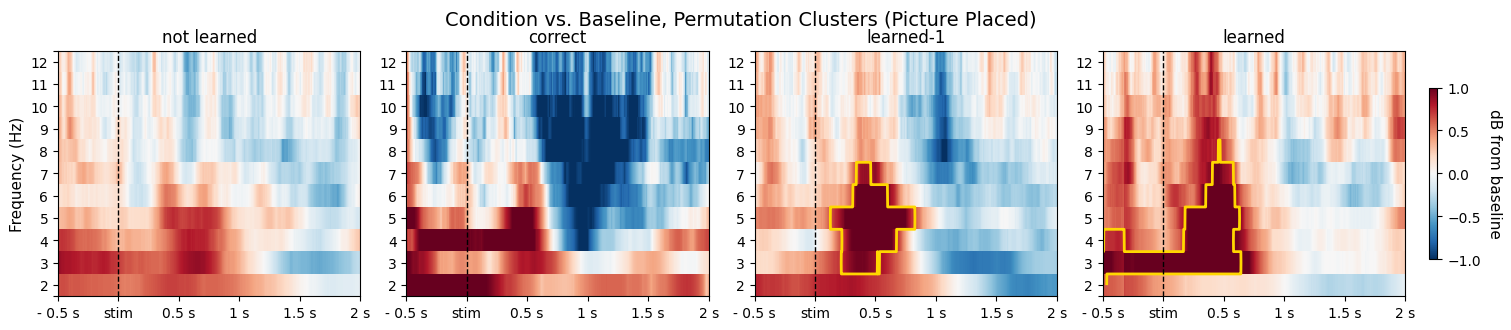

In [36]:
# [INFO] CHANGE IF NEEDED
tfr_data                = dict_tfr_power_results_cond_avg
fname_statistics        = f"2.2.1 {stimulus}_stat_permutation_condition_vs_baseline.pkl"
individ_cbars           = False # individual color bars (True/False)
draw_cluster_contours   = True

# smoothing parameters
factor                  = 5
sigma                   = 0.7
bool_smooth             = False

# load statistics
with open(f"{path_results}/data/{fname_statistics}", 'rb') as f:
    statistics = pickle.load(f)
    

#********** PLOT RESULTS **********#
fig1, ax1 = plt.subplots(nrows=1, ncols=len(conditions), figsize=(15, 3), layout='compressed')
for i, condition in enumerate(conditions):
    print(f"\nCondition: {condition}")
    
    # get statistics
    T_obs               = statistics[condition]['T_obs']
    clusters            = statistics[condition]['clusters']
    cluster_p_values    = statistics[condition]['cluster_p_values']
    
    # create cluster mask based on p-values
    cluster_mask = np.full_like(T_obs, np.nan)
    for cid, (c, p_val) in enumerate(zip(clusters, cluster_p_values)):
        if p_val <= alpha:
            print(f"SIGNIFICANT: cluster {cid+1} with p-value {p_val}")
            cluster_mask[c] = T_obs[c]
        else:
            print(f"NOT SIGNIFICANT: cluster {cid+1} with p-value {p_val}")
    
    # get clusters indexes (flattened shape)
    idx = np.where(np.isnan(cluster_mask) == False)
    
    if draw_cluster_contours:
        # binary mask
        tfr_plot_mask                   = np.zeros_like(T_obs)
        tfr_plot_mask[idx[0], idx[1]]   = 1
    else:
        # time-frequency power for clusters only
        tfr_plot_mask                   = np.full_like(T_obs, np.nan)
        tfr_plot_mask[idx[0], idx[1]]   = tfr_data[condition][idx[0], idx[1]] # set cluster indexes to tfr_data values
        # tfr_plot_mask       = tfr_plot_mask.reshape(n_frequencies, n_timepoints) # reshape to time-frequency shape
        
    
    # ********* TIME-FREQUENCY POWER *********
    if bool_smooth:
        tfr_data       = zoom(tfr_data, factor)
        tfr_plot_mask  = zoom(tfr_plot_mask, factor)
        tfr_data       = gaussian_filter(tfr_data, sigma)
        tfr_plot_mask  = gaussian_filter(tfr_plot_mask, sigma)
    
    if draw_cluster_contours:
        im1 = ax1[i].imshow(
            tfr_data[condition],
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_data[condition]) if individ_cbars else -1,
            vmax=np.max(tfr_data[condition]) if individ_cbars else 1,
            cmap='RdBu_r',
            interpolation='none'
        )
        ax1[i].contour(
            tfr_plot_mask,
            colors='gold', 
            levels=[0.5], 
            extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
            linewidths=2.
        )
    else:
        ax1[i].imshow(
            tfr_data[condition],
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_data[condition]) if individ_cbars else -1,
            vmax=np.max(tfr_data[condition]) if individ_cbars else 1,
            cmap='gray',
            interpolation='none',
            # alpha=.5
        )
        im1 = ax1[i].imshow(
            tfr_plot_mask,
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_data[condition]) if individ_cbars else -1,
            vmax=np.max(tfr_data[condition]) if individ_cbars else 1,
            cmap='RdBu_r',
            interpolation='none'
        )
    ax1[i].set_title(f'{condition}', fontsize=12)
    ax1[0].set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
    ax1[i].set_yticks(yticks, ylabels, fontsize=10)
    ax1[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    ax1[i].axvline(x=255, color='black', linestyle='--', linewidth=1.) # add line at stimulus onset
    
    
    # add individual colorbars for plots in figure
    if individ_cbars:
        cbar1 = plt.colorbar(im1, ax=ax1[i], shrink=.7, pad=0.01, orientation="vertical")
        if i == len(conditions)-1:
            cbar1.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)

# add common colorbar for plots in figure
if not individ_cbars:
    cbar1 = plt.colorbar(im1, ax=ax1.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar1.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)

# add figure titles
fig1.suptitle(f"Condition vs. Baseline, Permutation Clusters ({stimulus})", fontsize=14, y=1.05, x=.49)

# save figures
fig1.savefig(f"{path_results}/2.2.1 {stimulus}_stat_condition_vs_baseline_perm_clusters.png", dpi=300, bbox_inches='tight')

# plt.close(fig)
plt.show()

#### 2.2.2 Condition vs. Condition

In [37]:
# excluding 'correct' condition from tuple as it is not important for analysis and instead considering new condition 'learned combined'
conditions_diffs    = ('not learned', 'learned-1', 'learned', 'learned combined')
conditions_pairs    = [('learned', 'not learned'), ('learned-1', 'not learned'), ('learned combined', 'not learned'), ('learned', 'learned-1')]
condtion_indices    = {'not learned': 0,
                       'learned-1': 2,
                       'learned': 3,
                       'learned combined': 4}
tfr_data        = arr_tfr_power_results_subj_avg

# ************ STATISTICS ************
alpha           = 0.05                                                                      # significance level
df              = len(subject_ids) - 1                                                      # degrees of freedom
threshold       = stats.t.ppf(1 - alpha / 2, df)                                            # divided by 2 for two-tailed test
stat_fun        = lambda x, y: stats.ttest_rel(x, y, axis=0, alternative='two-sided')[0]    # paired two-sample t-test
print(f"Threshold: {threshold}")


# ************ PERMUTATION TEST ************
statistics      = {f'{condition_a} and {condition_b}': {'T_obs': None, 'clusters': None, 'cluster_p_values': None, 'H0': None} for (condition_a, condition_b) in conditions_pairs}


for i, (condition_a, condition_b) in enumerate(conditions_pairs):
    print(f"\nCondition pair: {condition_a} vs {condition_b}")
    
    # get condition data and reshape data to fit permutation function
    tfr_condition_a = tfr_data[condtion_indices[condition_a]]#.reshape(len(subject_ids), -1)
    tfr_condition_b = tfr_data[condtion_indices[condition_b]]#.reshape(len(subject_ids), -1)
    
    # define combined input X to permutation function
    X = [tfr_condition_a, tfr_condition_b]
    
    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
        X,
        threshold=threshold,
        n_permutations=1000, 
        tail=1, 
        n_jobs=-1, 
        seed=23,
        out_type='mask',
        stat_fun=stat_fun)
    
    statistics[f'{condition_a} and {condition_b}']['T_obs'] = T_obs #.reshape(n_freqs, n_times) # reshape back to time-frequency shape
    statistics[f'{condition_a} and {condition_b}']['clusters'] = clusters
    statistics[f'{condition_a} and {condition_b}']['cluster_p_values'] = cluster_p_values
    statistics[f'{condition_a} and {condition_b}']['H0'] = H0
    
    del X, T_obs, clusters, cluster_p_values, H0
    
    
#********** SAVE STATISTICS RESULTS **********#
filename = f"{path_results}/data/2.2.2 {stimulus}_stat_permutation_condition_vs_condition.pkl"
with open(filename, 'wb') as f:
    pickle.dump(statistics, f)

Threshold: 2.2621571627409915

Condition pair: learned vs not learned
stat_fun(H1): min=-2.079143834381553 max=3.1108836606205537
Running initial clustering …
Found 11 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]


Condition pair: learned-1 vs not learned
stat_fun(H1): min=-2.845154855262666 max=3.681309286644368
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]


Condition pair: learned combined vs not learned
stat_fun(H1): min=-1.9598715636260489 max=3.839188451249402
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]


Condition pair: learned vs learned-1
stat_fun(H1): min=-2.5135158645236246 max=3.342131621024474
Running initial clustering …
Found 9 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]


Condition pair: learned vs not learned
NOT SIGNIFICANT: cluster 1 with p-value 0.292
NOT SIGNIFICANT: cluster 2 with p-value 0.698
NOT SIGNIFICANT: cluster 3 with p-value 0.323
NOT SIGNIFICANT: cluster 4 with p-value 0.782
NOT SIGNIFICANT: cluster 5 with p-value 0.539
NOT SIGNIFICANT: cluster 6 with p-value 0.494
NOT SIGNIFICANT: cluster 7 with p-value 0.498
NOT SIGNIFICANT: cluster 8 with p-value 0.675
NOT SIGNIFICANT: cluster 9 with p-value 0.778
NOT SIGNIFICANT: cluster 10 with p-value 0.609
NOT SIGNIFICANT: cluster 11 with p-value 0.764

Condition pair: learned-1 vs not learned
NOT SIGNIFICANT: cluster 1 with p-value 0.591
NOT SIGNIFICANT: cluster 2 with p-value 0.324
NOT SIGNIFICANT: cluster 3 with p-value 0.774
NOT SIGNIFICANT: cluster 4 with p-value 0.834
NOT SIGNIFICANT: cluster 5 with p-value 0.853

Condition pair: learned combined vs not learned
NOT SIGNIFICANT: cluster 1 with p-value 0.092
NOT SIGNIFICANT: cluster 2 with p-value 0.844
NOT SIGNIFICANT: cluster 3 with p-value

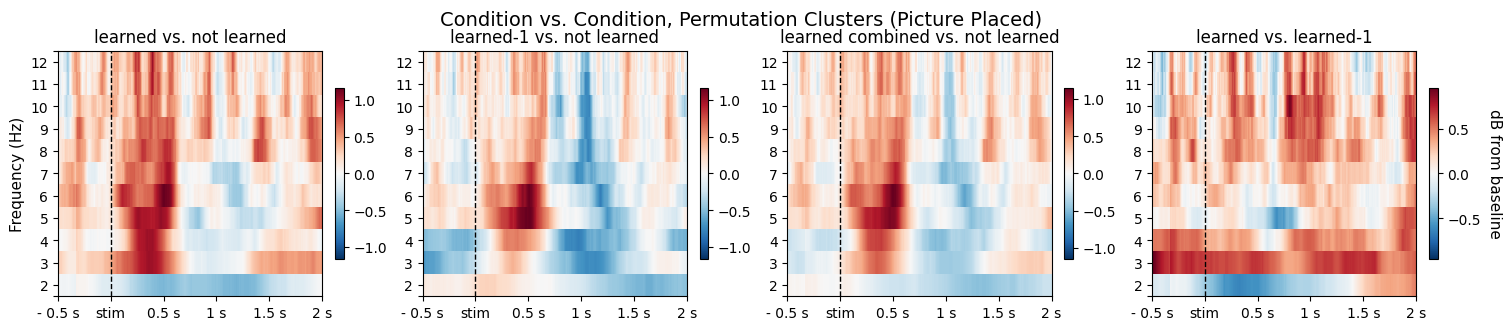

In [38]:
# [INFO] CHANGE IF NEEDED
tfr_data                = dict_tfr_power_results_cond_avg
fname_statistics        = f"2.2.2 {stimulus}_stat_permutation_condition_vs_condition.pkl"
individ_cbars           = True # individual color bars (True/False)
draw_cluster_contours   = True

# smoothing parameters
factor                  = 5
sigma                   = 0.7
bool_smooth             = False

# load statistics
with open(f"{path_results}/data/{fname_statistics}", 'rb') as f:
    statistics = pickle.load(f)
    

#********** PLOT RESULTS **********#
fig1, ax1 = plt.subplots(nrows=1, ncols=len(conditions), figsize=(15, 3), layout='compressed')
for i, (condition_a, condition_b) in enumerate(conditions_pairs):
    print(f"\nCondition pair: {condition_a} vs {condition_b}")
    
    # get time-frequency power difference between conditions
    tfr_diff_data = tfr_data[condition_a] - tfr_data[condition_b]
    
    # get statistics
    T_obs               = statistics[f'{condition_a} and {condition_b}']['T_obs']
    clusters            = statistics[f'{condition_a} and {condition_b}']['clusters']
    cluster_p_values    = statistics[f'{condition_a} and {condition_b}']['cluster_p_values']
    
    # create cluster mask based on p-values
    cluster_mask = np.full_like(T_obs, np.nan)
    for cid, (c, p_val) in enumerate(zip(clusters, cluster_p_values)):
        if p_val <= alpha:
            print(f"SIGNIFICANT: cluster {cid+1} with p-value {p_val}")
            cluster_mask[c] = T_obs[c]
        else:
            print(f"NOT SIGNIFICANT: cluster {cid+1} with p-value {p_val}")
    
    # get clusters indexes (flattened shape)
    idx = np.where(np.isnan(cluster_mask) == False)
    
    if draw_cluster_contours:
        # binary mask
        tfr_plot_mask                   = np.zeros_like(T_obs)
        tfr_plot_mask[idx[0], idx[1]]   = 1
    else:
        # time-frequency power for clusters only
        tfr_plot_mask                   = np.full_like(T_obs, np.nan)
        tfr_plot_mask[idx[0], idx[1]]   = tfr_diff_data[idx[0], idx[1]] # set cluster indexes to tfr_data values
        
        
    # ********* TIME-FREQUENCY POWER *********
    if bool_smooth:
        tfr_data       = zoom(tfr_data, factor)
        tfr_plot_mask  = zoom(tfr_plot_mask, factor)
        tfr_data       = gaussian_filter(tfr_data, sigma)
        tfr_plot_mask  = gaussian_filter(tfr_plot_mask, sigma)
        
    if draw_cluster_contours:
        im1 = ax1[i].imshow(
            tfr_diff_data,
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_diff_data) if individ_cbars else -1,
            vmax=np.max(tfr_diff_data) if individ_cbars else 1,
            cmap='RdBu_r',
            interpolation='none'
        )
        ax1[i].contour(
            tfr_plot_mask,
            colors='gold', 
            levels=[0.5], 
            extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
            linewidths=2.
        )
    else:
        ax1[i].imshow(
            tfr_diff_data,
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_diff_data) if individ_cbars else -1,
            vmax=np.max(tfr_diff_data) if individ_cbars else 1,
            cmap='gray',
            interpolation='none',
            # alpha=.5
        )
        im1 = ax1[i].imshow(
            tfr_plot_mask,
            aspect='auto',
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            origin='lower',
            vmin=-np.max(tfr_diff_data) if individ_cbars else -1,
            vmax=np.max(tfr_diff_data) if individ_cbars else 1,
            cmap='RdBu_r',
            interpolation='none'
        )
    ax1[i].set_title(f'{condition_a} vs. {condition_b}', fontsize=12)
    ax1[0].set_ylabel('Frequency (Hz)', fontsize=11) # only set ylabel for left most plots
    ax1[i].set_yticks(yticks, ylabels, fontsize=10)
    ax1[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    ax1[i].axvline(x=255, color='black', linestyle='--', linewidth=1.) # add line at stimulus onset
    
    
    # add individual colorbars for plots in figure
    if individ_cbars:
        cbar1 = plt.colorbar(im1, ax=ax1[i], shrink=.7, pad=0.01, orientation="vertical")
        if i == len(conditions)-1:
            cbar1.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)

# add common colorbar for plots in figure
if not individ_cbars:
    cbar1 = plt.colorbar(im1, ax=ax1.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar1.ax.set_ylabel("dB from baseline", rotation=270, labelpad=15, fontsize=11)

# add figure titles
fig1.suptitle(f"Condition vs. Condition, Permutation Clusters ({stimulus})", fontsize=14, y=1.05, x=.49)

# save figures
fig1.savefig(f"{path_results}/2.2.2 {stimulus}_stat_condition_vs_condition_perm_clusters.png", dpi=300, bbox_inches='tight')

# plt.close(fig)
plt.show()

# 3. Window-of-Interest

### 3.0 Helper Functions

In [39]:
def cut_tfr_data(tfr_data, stimulus_onset, fs, freq_start, freq_end, time_start, time_end):
    """cut_tfr_data Cut time-frequency power data for a specific time-frequency range and average area.

    Args:
        tfr_data (2darray): Time-frequency power data to cut.
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        freq_start (float): The start frequency of the range to cut the time-frequency power data in Hz.
        freq_end (float): The end frequency of the range to cut the time-frequency power data in Hz.
        time_start (float): The start time of the range to cut the time-frequency power data in seconds.
        time_end (float): The end time of the range to cut the time-frequency power data in seconds.

    Returns:
        tfr_data_cut (float): The average time-frequency power data for the specified range.
        freq_start_idx (int): The start frequency index of the range.
        freq_end_idx (int): The end frequency index of the range.
        time_start_idx (int): The start time index of the range.
        time_end_idx (int): The end time index of the range.
    """    
    # convert frequency range to indices
    freq_start_idx = np.where(frequencies == freq_start)[0][0].astype(int)
    freq_end_idx = np.where(frequencies == freq_end)[0][0].astype(int) + 1

    # convert time range to indices with respect to the stimulus onset
    time_start_idx = np.floor(stimulus_onset + (time_start * fs)).astype(int)
    time_start_idx = 0 if time_start_idx < 0 else time_start_idx
    time_end_idx = np.floor(stimulus_onset + (time_end * fs)).astype(int)
    
    # cut time-frequency power data and average flattened array
    tfr_data_cut = np.mean(tfr_data[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx], axis=None)
    return tfr_data_cut, freq_start_idx, freq_end_idx, time_start_idx, time_end_idx

def barplot_annotate_brackets(ax, num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
    
    ax.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs)
    

def compute_standard_error(tfr_data_subs_avg, subject_ids, stimulus_onset, fs, freq_start, freq_end, time_start, time_end):
    """compute_standard_error Computes the standard error for each condition across subjects.

    Args:
        tfr_data_subs_avg (dict): A dictionary containing the time-frequency power data for all subjects.
        subject_ids (list): A list of all subjects.
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        freq_start (float): The start frequency of the range to cut the time-frequency power data.
        freq_end (float): The end frequency of the range to cut the time-frequency power data.
        time_start (float): The start time of the range to cut the time-frequency power data.
        time_end (float): The end time of the range to cut the time-frequency power data.

    Returns:
        stderror (dict): A dict containing the standard error for each condition.
    """
    means = []
    for i, sub_id in enumerate(subject_ids):
        # cut time-frequency power data for each subject and average flattened array
        # check if tfr_data_subs_avg is array
        if isinstance(tfr_data_subs_avg, np.ndarray):
            tfr_data_window_avg, _, _, _, _ = cut_tfr_data(tfr_data_subs_avg[i], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
        else:
            tfr_data_window_avg, _, _, _, _ = cut_tfr_data(tfr_data_subs_avg[sub_id], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
        means.append(tfr_data_window_avg)
    # compute standard error
    stderror = np.std(means, axis=0) / np.sqrt(len(means))
    return stderror


def get_all_subjects_cut_data(tfr_data_subjects_avg, subject_ids, condition, stimulus_onset, fs, freq_start, freq_end, time_start, time_end):
    """get_all_subjects_cut_data Get time-frequency power data for all subjects individually in a condition.

    Args:
        tfr_data_subjects_avg (dict): A dictionary containing the time-frequency power data for each subject.
        subject_ids (list): A list of subject ids to get the time-frequency power data for.
        condition (str): The condition to get the time-frequency power data for.
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        freq_start (float): The start frequency of the range to cut the time-frequency power data.
        freq_end (float): The end frequency of the range to cut the time-frequency power data.
        time_start (float): The start time of the range to cut the time-frequency power data.
        time_end (float): The end time of the range to cut the time-frequency power data.

    Returns:
        dict: A dictionary containing the time-frequency power data for all subjects in a condition.
    """    
    tfr_data_cut_subs = {s: None for s in subject_ids}
    
    for sub_id in subject_ids:
        # cut time-frequency power data for each subject and average flattened array
        tfr_data_cut_subs[sub_id], _, _, _, _ = cut_tfr_data(tfr_data_subjects_avg[condition][sub_id], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)

    return tfr_data_cut_subs

### 3.2 Cut Window-of-Interest

Frequency range:	3 - 6 Hz
Time range:		0.25 - 0.6 s
Frequency indices:	1 - 5
Time indices:		383 - 562


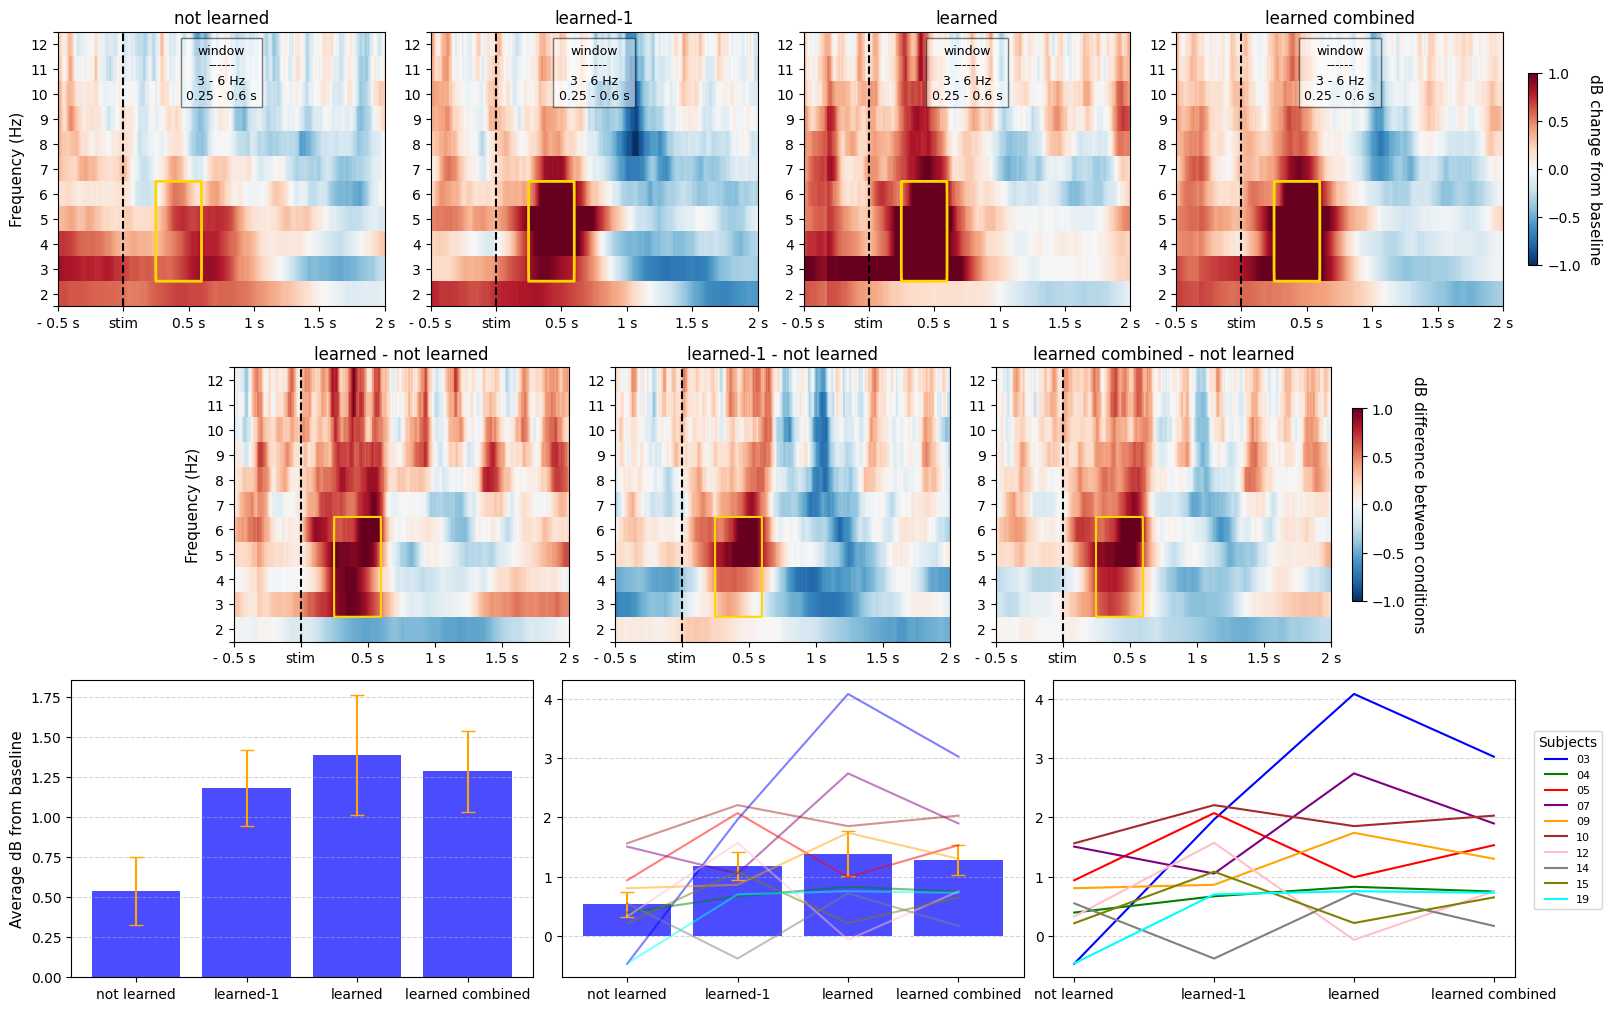

In [40]:
# [IMPORTANT] CHANGE AS NEEDED:
bool_save = True
#   - condition: condition to cut data from
#   - freq_start, freq_end: frequency range to cut data from
#   - time_start, time_end: time range to cut data from
conditions_cut          = ['not learned', 'learned-1', 'learned', 'learned combined']
condition_pairs_cut     = [('learned', 'not learned'), ('learned-1', 'not learned'), ('learned combined', 'not learned'), (None, None)]
freq_start, freq_end    = 3, 6      # frequency range to cut (in Hz)
time_start, time_end    = 0.25, 0.6   # time range to cut (in seconds)

# common parameters
individ_cbars       = False
stimulus_onset      = 255
fs                  = 512
# add 11 colors in a list to pass to scatter plot for each subject
subject_colors      = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black']

# initialize dictionary to store cut data and errors
tfr_data_cut_conds  = {f'{condition}': None for condition in conditions_cut}
tfr_data_cut_subs   = {s: {f'{condition}': None for condition in conditions_cut} for s in subject_ids}
errors              = {f'{condition}': None for condition in conditions_cut}

# initialize figure
fig = plt.figure(figsize=(16, 10), layout="constrained")
subfigs = fig.subfigures(nrows=3, ncols=1)
# FIGURE 1: time-frequency power (individual condition)
axs0 = subfigs[0].subplots(nrows=1, ncols=len(conditions_cut))
axs0 = axs0.flatten()

# FIGURE 2: time-frequency power (condition difference)
gs_kw = dict(width_ratios=[0.5, 1, 1, 1, 0.5])
axs1 = subfigs[1].subplots(nrows=1, ncols=5, gridspec_kw=gs_kw)
axs1 = axs1.flatten()
axs1[0].axis('off')
axs1[-1].axis('off')
axs1 = axs1[1:-1]
# subfigs[1].set_facecolor('lightblue')
# FIGURE 3: bar plot
axs2 = subfigs[2].subplots(nrows=1, ncols=3)
axs2 = axs2.flatten()

for i, (condition, (pair_a, pair_b)) in enumerate(zip(conditions_cut, condition_pairs_cut)):
    # get time-frequency power data for condition
    tfr_data_condition  = dict_tfr_power_results_cond_avg[condition]
    # get time-frequency power for subjects in condition
    tfr_data_subjects   = dict_tfr_power_results_subj_avg[condition]
    
    # get time-frequency power difference between pair of conditions
    if pair_a is not None:
        tfr_data_diff   = np.subtract(dict_tfr_power_results_cond_avg[pair_a], dict_tfr_power_results_cond_avg[pair_b])
    
    # cut data for condition
    tfr_data_cut_conds[condition], freq_start_idx, freq_end_idx, time_start_idx, time_end_idx = cut_tfr_data(tfr_data_condition, stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
    for sub_id in subject_ids:
        tfr_data_cut_subs[sub_id][condition], _, _, _, _ = cut_tfr_data(tfr_data_subjects[sub_id], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
    
    # calculate error (standard deviation is used as error)
    errors[condition] = np.std(tfr_data_condition, axis=None)
    
    if i == 0:
        print(f"Frequency range:\t{freq_start} - {freq_end} Hz")
        print(f"Time range:\t\t{time_start} - {time_end} s")
        print(f"Frequency indices:\t{freq_start_idx} - {freq_end_idx}")
        print(f"Time indices:\t\t{time_start_idx} - {time_end_idx}")
    
    # create a binary mask to draw contour around the cut area
    mask = np.zeros_like(tfr_data_condition)
    mask[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx] = 1

    # ****** PLOT INDIVIDUAL CONDITION ****** #
    im0 = axs0[i].imshow(
        tfr_data_condition, 
        extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
        vmax=np.max(tfr_data_condition) if individ_cbars else 1,
        vmin=-np.max(tfr_data_condition) if individ_cbars else -1,
        aspect='auto', 
        origin='lower', 
        cmap='RdBu_r', 
        interpolation='none')
    axs0[i].contour(
        mask, 
        colors='gold', 
        levels=[0.5], 
        extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
        linewidths=2)
    axs0[i].set_title(f"{condition}", fontsize=12)
    axs0[0].set_ylabel("Frequency (Hz)", fontsize=11)
    axs0[i].set_yticks(yticks, ylabels, fontsize=10)
    axs0[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
    axs0[i].axvline(x=stimulus_onset, color='black', linestyle='--', linewidth=1.5)
    text = f"window\n------\n{freq_start} - {freq_end} Hz\n{time_start} - {time_end} s"
    axs0[i].text(0.5, 0.85, text, fontsize=9, ha='center', va='center', transform=axs0[i].transAxes, color='black', bbox=dict(facecolor='white', alpha=0.5))

    # ****** PLOT CONDITION DIFFERENCE ****** #
    if pair_a is not None:
        im1 = axs1[i].imshow(
            tfr_data_diff, 
            extent=[timepoints[0], timepoints[-1], frequencies_plot[0], frequencies_plot[-1]],
            vmax=np.max(tfr_data_diff) if individ_cbars else 1,
            vmin=-np.max(tfr_data_diff) if individ_cbars else -1,
            aspect='auto', 
            origin='lower', 
            cmap='RdBu_r', 
            interpolation='none')
        axs1[i].contour(
            mask, 
            colors='gold', 
            levels=[0.5], 
            extent=[timepoints[0], timepoints[-1], frequencies[0], frequencies[-1]], 
            linewidths=1.5)
        axs1[i].set_title(f"{pair_a} - {pair_b}", fontsize=12)
        axs1[0].set_ylabel("Frequency (Hz)", fontsize=11)
        axs1[i].set_yticks(yticks, ylabels, fontsize=10)
        axs1[i].set_xticks(xticks, xlabels, rotation=0, fontsize=10)
        axs1[i].axvline(x=stimulus_onset, color='black', linestyle='--', linewidth=1.5)
    else:
        pass
    
    # add individual colorbars for plots in figure
    if individ_cbars:
        if pair_a is not None: cbar0 = plt.colorbar(im0, ax=axs0[i], shrink=.7, pad=0.01, orientation="vertical")
        cbar1 = plt.colorbar(im1, ax=axs1[i], shrink=.7, pad=0.01, orientation="vertical")
        if i == len(conditions_cut)-2: cbar0.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)
        if i == len(conditions_cut)-1: cbar1.ax.set_ylabel("dB difference between conditions", rotation=270, labelpad=15, fontsize=11)

# add common colorbar for plots in figure
if not individ_cbars:
    cbar0 = plt.colorbar(im0, ax=axs0.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar1 = plt.colorbar(im1, ax=axs1.ravel().tolist(), shrink=.7, pad=0.01, orientation="vertical")
    cbar0.ax.set_ylabel("dB change from baseline", rotation=270, labelpad=15, fontsize=11)
    cbar1.ax.set_ylabel("dB difference between conditions", rotation=270, labelpad=15, fontsize=11)

# ****** BAR PLOT ****** #
stderror = {condition: None for condition in conditions_cut}
for condition in conditions_cut:
    # compute standard error
    stderror[condition] = compute_standard_error(dict_tfr_power_results_subj_avg[condition], subject_ids, stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
se          = [stderror[condition] for condition in conditions_cut]
bars        = conditions_cut
heights     = [tfr_data_cut_conds[condition] for condition in conditions_cut]

# 1st plot only bar and error
# axs2[0].axis('off')
axs2[0].bar(
    bars, 
    heights, 
    yerr=se,
    capsize=5,
    color='blue', 
    ecolor='orange',
    alpha=0.7)
axs2[0].set_ylabel("Average dB from baseline", fontsize=11)
axs2[0].grid(axis='y', linestyle='--', alpha=0.5)
# Shrink current axis by 5%
# box = axs2[0].get_position()
# axs2[0].set_position([box.x0, box.y0, box.width * 0.95, box.height])

# 2nd plot bars, error, and individual subject data points
axs2[1].bar(
    bars, 
    heights, 
    yerr=se,
    capsize=5,
    color='blue', 
    ecolor='orange',
    alpha=0.7)
# individual color coded subject data points
for sub_id, sub_color in zip(subject_ids, subject_colors):
    axs2[1].plot(
        [f'{condition}' for condition in conditions_cut], 
        [tfr_data_cut_subs[sub_id][condition] for condition in conditions_cut], 
        color=sub_color,
        label=sub_id,
        alpha=0.5)
axs2[1].grid(axis='y', linestyle='--', alpha=0.5)
# Shrink current axis by 5%
# box = axs2[1].get_position()
# axs2[1].set_position([box.x0, box.y0, box.width * 0.95, box.height])

# 3rd plot only individual subject data points
# axs2[2].axis('off')
for sub_id, sub_color in zip(subject_ids, subject_colors):
    axs2[2].plot(
        [f'{condition}' for condition in conditions_cut], 
        [tfr_data_cut_subs[sub_id][condition] for condition in conditions_cut], 
        color=sub_color,
        label=sub_id)
axs2[2].grid(axis='y', linestyle='--', alpha=0.5)
# Shrink current axis by 5%
# box = axs2[2].get_position()
# axs2[2].set_position([box.x0, box.y0, box.width * 0.95, box.height])
axs2[2].legend(title='Subjects', loc='upper right', fontsize=8, bbox_to_anchor=(1.2, 0.85))

# add significance brackets
# barplot_annotate_brackets(axs2[1], 0, 1, 'p < 0.0001', np.arange(len(bars)), heights, fs=10)

# save figure
if bool_save:
    fig.savefig(f"{path_results}/3.2 {stimulus}_window-of-interest___{freq_start}-{freq_end}_Hz___{time_start}-{time_end}_s___.png", dpi=300, bbox_inches='tight')
plt.show()

# save cut data
if bool_save:
    # save cut data for conditions
    with open(f"{path_results}/data/3.2 {stimulus}_window_conds___{freq_start}-{freq_end}_Hz___{time_start}-{time_end}_s___.pkl", 'wb') as f:
        pickle.dump(tfr_data_cut_conds, f)
    # save cut data for subjects
    with open(f"{path_results}/data/3.2 {stimulus}_window_subs___{freq_start}-{freq_end}_Hz___{time_start}-{time_end}_s___.pkl", 'wb') as f:
        pickle.dump(tfr_data_cut_subs, f)